# LightGBM

Script com foco no processo de forecast com previsão multi-step. <br>Método: direct prediction (ver https://machinelearningmastery.com/multi-step-time-series-forecasting/)


In [1]:
#https://www.youtube.com/watch?v=fG8H-0rb0mY
#https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
#lgb.__version__

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [3]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

def train_test_split(data, n_test):
    """
    Função para partir or dados em treino e teste
    """
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def lightgbm_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = lightgbm_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected = %.1f, predicted = %.1f' % (testy, yhat))
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:, -1], predictions))    
    return mae, mape, rmse, test[:, -1], predictions

def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    #forecast.reset_index(drop = True, inplace = True)
    #test.reset_index(drop = True, inplace = True)
    #errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    # else:
    #     errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    # arredondamento
    # for key, item in measures.items():
    #     measures[key] = round(measures[key], 2)
    return measures


# MANUALMENTE

In [7]:
df = load_data()
df.interpolate(method = "linear", inplace = True)
values = df.values.tolist()
lag = 10 # número de variáveis explicativas
n_test = outs = 5 # tamanho da partição de teste (= número de variáveis explicadas)
data = series_to_supervised(values, n_in = lag, n_out = outs, dropnan=False)

In [8]:
#n_test = 31
train, test = train_test_split(data, n_test)
train.dropna(inplace = True)

In [9]:
train

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4)
10,4800.650000,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,6435.912500
11,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,6435.912500,5621.175000
12,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,6435.912500,5621.175000,7234.966667
13,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,6435.912500,5621.175000,7234.966667,7517.372917
14,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,6435.912500,5621.175000,7234.966667,7517.372917,7391.795833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8178,11361.001881,11305.707062,10060.549787,8994.856748,11424.087542,11964.909375,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708
8179,11305.707062,10060.549787,8994.856748,11424.087542,11964.909375,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833
8180,10060.549787,8994.856748,11424.087542,11964.909375,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875
8181,8994.856748,11424.087542,11964.909375,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250


In [22]:
df.iloc[-15:] # última partição de teste

,load_mwmed
date,
2022-05-17,11964.909375
2022-05-18,12269.051375
2022-05-19,12021.415458
2022-05-20,11802.526458
2022-05-21,10256.970375
2022-05-22,8938.579125
2022-05-23,11713.104333
2022-05-24,12054.195042
2022-05-25,12186.721375


In [36]:
folds = 5
h = 10
rows = df.shape[0]
for fold in range(folds,0,-1):
    #print(fold)
    #print(df.index[rows-(fold*h)-1])
    slide = rows-(fold*h)#-1
    range_ = df.iloc[:slide]
    #print(range_.tail())
    tr_init = df.index[0]
    tr_end = range_.index[-1]
    te_init = df.index[range_.shape[0]]
    te_end = df.index[range_.shape[0]+(h-1)]
    print(f"training set {fold}: {tr_init} to {tr_end}\n  test set: {te_init} to {te_end}")

training set 5: 2000-01-01 00:00:00 to 2022-04-11 00:00:00
  test set: 2022-04-12 00:00:00 to 2022-04-21 00:00:00
training set 4: 2000-01-01 00:00:00 to 2022-04-21 00:00:00
  test set: 2022-04-22 00:00:00 to 2022-05-01 00:00:00
training set 3: 2000-01-01 00:00:00 to 2022-05-01 00:00:00
  test set: 2022-05-02 00:00:00 to 2022-05-11 00:00:00
training set 2: 2000-01-01 00:00:00 to 2022-05-11 00:00:00
  test set: 2022-05-12 00:00:00 to 2022-05-21 00:00:00
training set 1: 2000-01-01 00:00:00 to 2022-05-21 00:00:00
  test set: 2022-05-22 00:00:00 to 2022-05-31 00:00:00


In [ ]:
response_vars = data.columns[-(outs):]

predictions = list()
for h, response in enumerate(response_vars):
    cols = [x for x in data.columns[:lag]]
    varname = response
    cols.append(varname)
    # if h == 0:
    #     varname = "var1(t)"
    #     cols.append(varname)
    #     data_ = train[cols]
    #     data_ = data_.iloc[:, :]        
    # else:
    #     varname = f"var1(t+{h})"
    #     cols.append(varname)
    data_ = train[cols]
    nrows = data_.shape[0]
    data_ = data_.iloc[:nrows-h, :] 
    data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
    model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
    model.fit(data_X, data_y)
    #teste = train.loc[:, :"var1(t-1)"].iloc[-1,:] # t + 3 (observado = 12.054,20)
    testX, testy = test.reset_index(drop=True).loc[0, :"var1(t-1)"], test.reset_index(drop=True).loc[0, varname]
    pred = model.predict([testX])[0]
    print(f"Predicting {varname}\n  > expected: {testy}, predicted: {pred}")
    predictions.append(pred)
    #print(testX)
    #print(test["var1(t)"].iloc[h + 0])

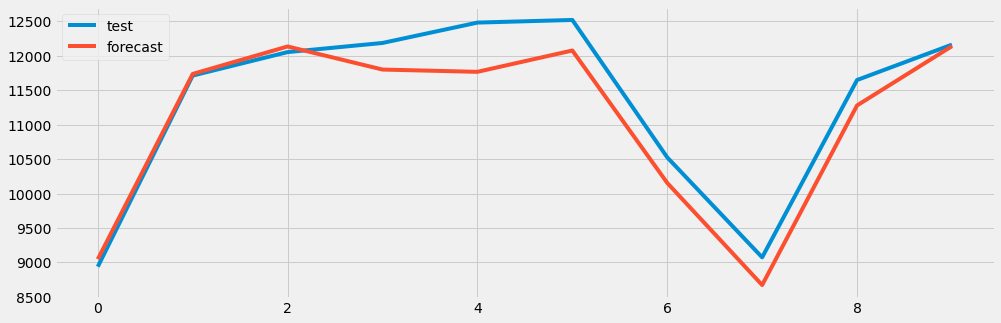

In [24]:
plt.figure()

plt.plot(test["var1(t)"].reset_index(drop = True), label = "test")
plt.plot(predictions, label = "forecast")

plt.legend()

plt.show()

In [25]:
measures = get_measures(pd.Series(predictions), test["var1(t)"])
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,1.311804e+06,292.251882,131180.40305,362.188353,0.025835,2.632413


In [9]:
def multi_step_forecast(data, lag, n):
    n_test = outs = n
    data = series_to_supervised(values, n_in = lag, n_out = outs, dropnan=False)
    train, test = train_test_split(data, n_test)
    train.dropna(inplace = True)
    response_vars = data.columns[-(outs):]
    predictions = list()
    for h, response in enumerate(response_vars):
        cols = [x for x in data.columns[:lag]]
        cols.append(response)
        data_ = train[cols]
        nrows = data_.shape[0]
        data_ = data_.iloc[:nrows-h, :] 
        data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
        model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
        model.fit(data_X, data_y)
        #teste = train.loc[:, :"var1(t-1)"].iloc[-1,:] # t + 3 (observado = 12.054,20)
        testX, testy = test.reset_index(drop=True).loc[0, :"var1(t-1)"], test.reset_index(drop=True).loc[0, response]
        pred = model.predict([testX])[0]
        print(f"Predicting {response}\n  > expected: {testy}, predicted: {pred}")
        predictions.append(pred)
        measures = get_measures(pd.Series(pred), test["var1(t)"])
        df_measures = pd.DataFrame([measures])
    #return predictions
    return df_measures

In [18]:
df = load_data()
df.interpolate(method = "linear", inplace = True)
values = df.values.tolist()
data = series_to_supervised(values, n_in = 60, n_out = 10, dropnan=False)
data

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4800.650000,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,12049.438875,12864.373792,12801.830000,11890.737708,11762.593583,10305.348750,9318.594333,12069.142875,11989.101125,12151.257583,...,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN
8184,12864.373792,12801.830000,11890.737708,11762.593583,10305.348750,9318.594333,12069.142875,11989.101125,12151.257583,12512.483583,...,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN
8185,12801.830000,11890.737708,11762.593583,10305.348750,9318.594333,12069.142875,11989.101125,12151.257583,12512.483583,12271.662917,...,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8186,11890.737708,11762.593583,10305.348750,9318.594333,12069.142875,11989.101125,12151.257583,12512.483583,12271.662917,10395.100000,...,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

pred = multi_step_forecast(values, lag = 60, n = 10)

In [20]:
train, test = train_test_split(data, 10)

In [23]:
pd.Series(pred)

0     9046.776643
1    11736.988115
2    12135.796535
3    11800.582028
4    11767.521200
5    12077.384335
6    10154.813216
7     8671.974977
8    11279.625790
9    12140.479841
dtype: float64

In [24]:
measures = get_measures(pd.Series(pred), test["var1(t)"])
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,1.311804e+06,292.251882,131180.40305,362.188353,0.025835,2.632413


In [27]:
def multi_step_forecast(data, lag, n):
    n_test = outs = n
    data = series_to_supervised(values, n_in = lag, n_out = outs, dropnan=False)
    train, test = train_test_split(data, n_test)
    train.dropna(inplace = True)
    response_vars = data.columns[-(outs):]
    predictions = list()
    for h, response in enumerate(response_vars):
        cols = [x for x in data.columns[:lag]]
        cols.append(response)
        data_ = train[cols]
        nrows = data_.shape[0]
        data_ = data_.iloc[:nrows-h, :] 
        data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
        model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
        model.fit(data_X, data_y)
        testX, testy = test.reset_index(drop=True).loc[0, :"var1(t-1)"], test.reset_index(drop=True).loc[0, response]
        pred = model.predict([testX])[0]
        print(f"Predicting {response}\n  > expected: {testy}, predicted: {pred}")
        predictions.append(pred)
    measures = get_measures(pd.Series(predictions), test["var1(t)"])
    df_measures = pd.DataFrame([measures])
    return df_measures
df = load_data()
df.interpolate(method = "linear", inplace = True)
values = df.values.tolist()
measures = multi_step_forecast(values, lag=60, n=3)

Predicting var1(t)
  > expected: 9074.21125, predicted: 9056.763969268766
Predicting var1(t+1)
  > expected: 11648.70958333, predicted: 11965.178900540233
Predicting var1(t+2)
  > expected: 12162.75679167, predicted: 12346.377400062667
